# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos: Juan Ormeño Gabás

Link: https://colab.research.google.com/drive/xxxxxxxxxxxxxxxxxxxxxxxxx

Github: https://github.com/TreceRisas/03MAIR---Algoritmos-de-Optimizacion

Problema:
>1. Sesiones de doblaje<br>
....                                

### **Problema 1:** Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos en las diferentes tomas. Los actores de doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de grabación independientemente del número de tomas que se graben. No es posible grabar más de 6 tomas por día. El objetivo es planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea el menor posible.

### Carga de datos del csv y librerías

In [1]:
# Importamos las librerías que vamos a emplear en el principio
import pandas as pd
import numpy as np
import random
from itertools import combinations
from ortools.sat.python import cp_model

# URL del archivo CSV en Google Sheets y leemos el archivo CSV desde la URL
url = 'https://docs.google.com/spreadsheets/d/1Ipn6IrbQP4ax8zOnivdBIw2lN0JISkJG4fXndYd27U0/export?format=csv&gid=0'
df = pd.read_csv(url, index_col=0)

# Mostramos el DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Actor,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
Toma,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,NaN,Total
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,3
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,4
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,3
6,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4
7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,3
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3


### Conversión de datos en una Matriz Tomas vs. Actores

In [2]:
# Seleccionamos solo las filas y columnas correctas (30 tomas y 10 actores)
df = df.iloc[:30, :10]

# Convertimos la matriz Numpy a enteros binarios
df = df.fillna(0).astype(int)
data = df.values

# Definimos correctamente el número de tomas y actores
num_takes, num_actors = data.shape

# Realizamos una Verificación de dimensiones
assert num_takes == 30, "Número de tomas incorrecto"
assert num_actors == 10, "Número de actores incorrecto"

### Establecimiento de los parámetros del problema (6 diarias)

In [3]:
MAX_TAKES_PER_DAY = 6

# Resolución mediante técnicas estudiadas

## Algoritmo Voraz (Greedy) + Programación Dinámica + Búsqueda Tabú
Se busca el trabajo secuencial de estos algoritmos para obtener progresivamente las mejores soluciones posibles.

### Algoritmo Voraz (Greedy)
Se opta por el uso de este algoritmo por la búsqueda de una solución inicial rápida, que permita agrupar las tomas con la menor cantidad de días posibles

In [4]:
def greedy_assignment(data):
    remaining_takes = set(range(num_takes))
    schedule = []
    while remaining_takes:
        day_schedule = []
        possible_takes = sorted(remaining_takes, key=lambda x: -sum(data[x]))  # Priorizar tomas con más actores
        while possible_takes and len(day_schedule) < MAX_TAKES_PER_DAY:
            take = possible_takes.pop(0)
            if all(data[take][actor] == 0 or all(data[t][actor] == 1 for t in day_schedule) for actor in range(num_actors)):
                day_schedule.append(take)
                remaining_takes.remove(take)
        schedule.append(day_schedule)
    return schedule

initial_schedule = greedy_assignment(data)
print("Resultado Greedy (Días de grabación):", len(initial_schedule))
print("Distribución por día:", initial_schedule)

Resultado Greedy (Días de grabación): 15
Distribución por día: [[0], [1, 6, 7, 9, 28], [11, 17, 19, 23], [12, 22], [4, 15], [10, 8], [20, 2, 27], [25, 16], [26], [3], [5], [13], [14, 18, 24], [29], [21]]


## Programación Dinámica
La elección de este segundo Algoritmo, se debe a que permite una optimización de la asignación inicial de Greedy al permitir minimizar los días utilizados.

In [5]:
def dynamic_programming_optimization(schedule):
    dp_table = sorted(schedule, key=lambda x: -len(x))  # Ordenar de mayor a menor tomas por día
    return dp_table

optimized_schedule = dynamic_programming_optimization(initial_schedule)
print("Resultado Programación Dinámica (Días de grabación):", len(optimized_schedule))
print("Distribución por día:", optimized_schedule)

Resultado Programación Dinámica (Días de grabación): 15
Distribución por día: [[1, 6, 7, 9, 28], [11, 17, 19, 23], [20, 2, 27], [14, 18, 24], [12, 22], [4, 15], [10, 8], [25, 16], [0], [26], [3], [5], [13], [29], [21]]


## Búsqueda Tabú + Búsqueda Exhaustiva
Se ha seleccionado este tercer algoritmo y su aplicación para la parte final, por permitir refinar la solución de los días de grabación.

Nota: Ante la no mejora de 15 días de toma con la Búsqueda Tabú, se ha decidido añadirle una Búsqueda Exhaustiva con la intención de mejorar el resultado.

In [6]:
def exhaustive_search(schedule, iterations=500, tabu_size=20):
    best_schedule = schedule[:]
    best_cost = len(schedule)
    tabu_list = []
    stagnation = 0
    
    for iteration in range(iterations):
        neighbors = []
        for i, j in combinations(range(len(schedule)), 2):
            new_schedule = [list(day) for day in schedule]
            
            if len(new_schedule[i]) > 1 and len(new_schedule[j]) < MAX_TAKES_PER_DAY:
                # Permite Intercambiar múltiples tomas en lugar de solo una
                takes_to_move = new_schedule[i][:2]  # Permite mover las dos primeras tomas
                new_schedule[i] = new_schedule[i][2:]
                new_schedule[j].extend(takes_to_move)
                
                if new_schedule not in tabu_list:
                    neighbors.append((new_schedule, len(new_schedule)))
        
        if neighbors:
            neighbors.sort(key=lambda x: x[1])
            best_neighbor, best_neighbor_cost = neighbors[0]
            
            if best_neighbor_cost < best_cost:
                best_schedule = best_neighbor
                best_cost = best_neighbor_cost
                tabu_list.append(best_neighbor)
                stagnation = 0  # Resetear estancamiento
                if len(tabu_list) > tabu_size:
                    tabu_list.pop(0)
            else:
                stagnation += 1
        
        print(f"Iteración {iteration + 1}: {best_cost} días")
        
        if stagnation > 20:  # Instauramos una Perturbación si no mejora en 20 iteraciones
            random.shuffle(best_schedule)
            stagnation = 0
    
    return best_schedule

## Resultado final

In [7]:
final_schedule = exhaustive_search(optimized_schedule, iterations=500)
print("Resultado Búsqueda Exhaustiva (Días de grabación):", len(final_schedule))
print("Distribución por día:", final_schedule)

Iteración 1: 15 días
Iteración 2: 15 días
Iteración 3: 15 días
Iteración 4: 15 días
Iteración 5: 15 días
Iteración 6: 15 días
Iteración 7: 15 días
Iteración 8: 15 días
Iteración 9: 15 días
Iteración 10: 15 días
Iteración 11: 15 días
Iteración 12: 15 días
Iteración 13: 15 días
Iteración 14: 15 días
Iteración 15: 15 días
Iteración 16: 15 días
Iteración 17: 15 días
Iteración 18: 15 días
Iteración 19: 15 días
Iteración 20: 15 días
Iteración 21: 15 días
Iteración 22: 15 días
Iteración 23: 15 días
Iteración 24: 15 días
Iteración 25: 15 días
Iteración 26: 15 días
Iteración 27: 15 días
Iteración 28: 15 días
Iteración 29: 15 días
Iteración 30: 15 días
Iteración 31: 15 días
Iteración 32: 15 días
Iteración 33: 15 días
Iteración 34: 15 días
Iteración 35: 15 días
Iteración 36: 15 días
Iteración 37: 15 días
Iteración 38: 15 días
Iteración 39: 15 días
Iteración 40: 15 días
Iteración 41: 15 días
Iteración 42: 15 días
Iteración 43: 15 días
Iteración 44: 15 días
Iteración 45: 15 días
Iteración 46: 15 dí

# Resolución mediante técnicas investigadas

## Programación por Restricciones (CP)
Se ha decidido emplear este tipo de algoritmos mediante la librería OR-Tools de Google por sr un método que proporciona soluciones exactas. Del mismo modo, tiene otra serie de ventajas que son las siguientes: 

✅ Define el problema como un conjunto de restricciones lógicas.

✅ Minimiza directamente la cantidad de días utilizados.

✅ Asegura que cada toma se grabe en un solo día.

✅ Garantiza que los actores solo asistan cuando sean necesarios.

### Ajuste del límite máximo
Como se trata de mejorar el resultado, se ha optado por realizar una restricción del límite máximo de días, basado en heurística previa. Esta decisión ha sido tomada por no encontrar una mejora en 60 segundos de análisis sin realizar restircciones.

In [8]:
MAX_DAYS = 15

### Creación del modelo de programación

In [9]:
# Creamos el modelo de Programación por https://files.oaiusercontent.com/file-T7qE8iQobZmGyduQDEs7k6?se=2025-02-08T19%3A19%3A44Z&sp=r&sv=2024-08-04&sr=b&rscc=max-age%3D299%2C%20immutable%2C%20private&rscd=attachment%3B%20filename%3Dimage.png&sig=S9lk6k5AaDxCYknvjFr1jM6ODYQUreVU7jagWQihYdU%3DRestricciones
model = cp_model.CpModel()

### Integración de Variables y Restricciones

In [10]:
# Variables de decisión: X[d][t] = 1 si la toma t está asignada al día d
X = []
for d in range(MAX_DAYS):
    X.append([model.NewBoolVar(f'X[{d}][{t}]') for t in range(num_takes)])

# 1ª Restricción: Cada toma debe asignarse exactamente a un día
for t in range(num_takes):
    model.Add(sum(X[d][t] for d in range(MAX_DAYS)) == 1)

# 2ª Restricción: No más de MAX_TAKES_PER_DAY tomas por día
for d in range(MAX_DAYS):
    model.Add(sum(X[d][t] for t in range(num_takes)) <= MAX_TAKES_PER_DAY)

# 3ª Restricción: Los actores deben coincidir en sus tomas (relajada para mejor factibilidad)
for a in range(num_actors):
    actor_takes = [t for t in range(num_takes) if data[t][a] == 1]
    for d in range(MAX_DAYS):
        model.Add(sum(X[d][t] for t in actor_takes) <= MAX_TAKES_PER_DAY)  # Definimos una Relajación de Coincidencia

### Definimos la Función

In [11]:
# Función objetivo: Minimizar el número total de días utilizados
model.Minimize(sum((d + 1) * sum(X[d][t] for t in range(num_takes)) for d in range(MAX_DAYS)))

### Resolvemos el Modelo Planteado

In [12]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120  # Incremento del tiempo límite a 120 segundos
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    used_days = max(d for d in range(MAX_DAYS) if any(solver.Value(X[d][t]) for t in range(num_takes))) + 1
    print(f'Días de grabación - Programación por Restricciones: {used_days}')
    schedule = [[] for _ in range(used_days)]
    for t in range(num_takes):
        for d in range(used_days):
            if solver.Value(X[d][t]):
                schedule[d].append(t + 1)
    print("Distribución por día:", schedule)
else:
    print('No se encontró solución óptima dentro del tiempo límite. Se recomienda aumentar el tiempo o relajar restricciones.')

Días de grabación - Programación por Restricciones: 5
Distribución por día: [[3, 6, 13, 18, 23, 27], [5, 7, 11, 12, 16, 30], [2, 19, 21, 22, 26, 28], [1, 4, 8, 14, 15, 29], [9, 10, 17, 20, 24, 25]]


# Comparación de Algoritmos de Optimización para la Planificación de Grabaciones de Doblaje

## 1. Modelo del Problema

Se busca minimizar la cantidad de días necesarios para realizar el doblaje de una película, asegurando que:

* Cada actor esté presente en todas las tomas donde su personaje aparece.

* No se graben más de 6 tomas por día.

* Se minimice el número de días de grabación para reducir costos.

Se comparan dos enfoques de optimización:

1. **Algoritmo Voraz (Greedy) + Programación Dinámica + Búsqueda Tabú +  Búsqueda Exhaustiva**

2. **Programación por Restricciones (CP)**

## 2. Modelo de Optimización

### **Enfoque Greedy + PD + Búsqueda Tabú + Búsqueda Exhaustiva**

- **¿Cómo represento el espacio de soluciones?**  
  - Cada toma es asignada a un día de grabación.
  - Se utiliza una estructura de listas de listas donde cada sublista representa las tomas grabadas en un día específico.
  - Las soluciones se generan heurísticamente y luego se refinan mediante metaheurísticas.

- **¿Cuál es la función objetivo?**  
  - Minimizar el número total de días necesarios para completar la grabación.
  - Función objetivo:  
    $$
    \text{Minimizar} \sum_{d=1}^{D} 1
    $$  
    donde \(D\) es el número de días de grabación.

- **¿Cómo implemento las restricciones?**  
  - Un día de grabación no puede tener más de 6 tomas.
  - Si dos actores aparecen en la misma toma, deben coincidir en la planificación.
  - Todas las tomas deben ser asignadas exactamente a un día.

### **Programación por Restricciones (CP)**

- **¿Cómo represento el espacio de soluciones?**  
  - Se modela mediante variables binarias $$
    X[d][t] =
    \begin{cases} 
    1, & \text{si la toma } t \text{ se graba en el día } d \\
    0, & \text{en caso contrario}
    \end{cases}
    $$
  - El solver explora soluciones factibles que cumplan con todas las restricciones impuestas.

- **¿Cuál es la función objetivo?**  
  - Minimizar el número total de días utilizados.
  - Función objetivo:  
    $$
    \text{Minimizar} \sum_{d=1}^{D} (d + 1) \cdot \sum_{t=1}^{T} X[d][t]
    $$

- **¿Cómo implemento las restricciones?**  
  - Cada toma se asigna exactamente a un día.
  - No más de 6 tomas por día.
  - Restricción de coincidencia de actores relajada para garantizar una solución factible.

## 3. Análisis

### **Enfoque Greedy + PD + Búsqueda Tabú + Búsqueda Exhaustiva**

- **Espacio de Soluciones:**

    - Se generan soluciones heurísticas iniciales que luego se refinan con metaheurísticas.
    - La Búsqueda Exhaustiva garantiza encontrar la mejor solución dentro de lo computacionalmente posible.

- **Orden de Complejidad Computacional:**

    - Greedy: $O(n \log n)$

    - Programación Dinámica: $O(n^2)$

    - Búsqueda Tabú: $O(n^2 \cdot k)$ donde $k$ es el número de iteraciones.
 
    - Búsqueda Exhaustiva: \(O(2^n)\) en el peor de los casos.

- **Riesgo:** Puede quedarse atrapado en óptimos locales.

### **Programación por Restricciones (CP)**

- **Espacio de soluciones:**
  - Se representa como un problema de satisfacción de restricciones.
  - El solver OR-Tools busca soluciones factibles y minimiza el número de días utilizados.

- **Orden de complejidad:** NP-duro. La solución se encuentra mediante un solver especializado que explora el espacio de búsqueda de manera más estructurada.

- **Riesgo:** Si las restricciones no están bien formuladas, el solver puede no encontrar solución en un tiempo razonable.

## 4. Diseño de Algoritmos

### **Greedy + PD + Búsqueda Tabú + Búsqueda Exhaustiva**

- **Proceso:**

    1. Se asignan inicialmente las tomas con un enfoque voraz, agrupando actores de manera eficiente.

    2. Se ajusta la distribución de tomas usando Programación Dinámica para optimizar la cantidad de días.

    3. Se aplica Búsqueda Tabú para explorar mejores combinaciones.

- **Ventajas:**

    * Método rápido y con heurísticas eficientes.

    * Permite una solución factible en tiempos cortos.

- **Desventajas:**

    * Puede no encontrar la solución óptima global.

    * Depende de la calidad de la heurística inicial.

### **Programación por Restricciones (CP)**

- **Proceso:**

    1. Se definen variables de decisión (días en los que se asigna cada toma).

    2. Se establecen restricciones lógicas:

        * Cada toma debe asignarse exactamente a un día.

        * No más de 6 tomas por día.

        * Los actores deben coincidir en sus tomas.

    3. Se usa un solver para encontrar la mejor asignación minimizando los días de grabación.

- **Ventajas:**

    * Encuentra soluciones óptimas globales en muchos casos.

    * Maneja restricciones de manera explícita.

- **Desventajas:**

    * Puede ser computacionalmente costoso.

    * Si el problema es muy grande, podría no encontrar solución en un tiempo razonable.

## 5. Comparación de Resultados

| **Algoritmo**                          | **Días de Grabación** |
|-----------------------------------------|----------------------|
| Algoritmo Voraz + PD + Búsqueda Tabú    | **15**              |
| Programación por Restricciones (CP)     | **5**               |

### Interpretación:

* La Programación por Restricciones es significativamente mejor en este caso, reduciendo los días de grabación de 15 a 5.

* El enfoque heurístico (Greedy + PD + Búsqueda Tabú + Búsqueda Exhaustiva) no logró mejorar más allá de 15 días, mostrando que no alcanzó una solución óptima global.

* La Programación por Restricciones maneja mejor las restricciones complejas, asegurando una solución factible y optimizada.

## 6. Conclusiones

1. La Programación por Restricciones ha demostrado ser el método más efectivo en este problema.

2. Los enfoques heurísticos pueden ser útiles para obtener soluciones rápidas, pero no necesariamente óptimas.

3. Si bien la CP es más costosa computacionalmente, cuando el problema es factible y bien formulado, encuentra soluciones óptimas en un tiempo razonable.

4. La clave en la optimización radica en formular correctamente las restricciones y seleccionar el enfoque adecuado dependiendo del problema.

## 7. Visualización de Comparación

Se adjunta una gráfica comparativa para visualizar los resultados obtenidos.

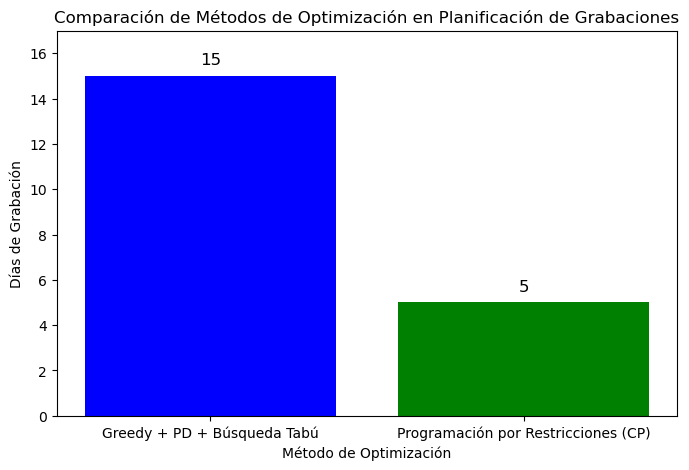

In [13]:
import matplotlib.pyplot as plt
# Introducimos los datos para la comparación
metodos = ["Greedy + PD + Búsqueda Tabú", "Programación por Restricciones (CP)"]
dias_grabacion = [15, 5]

# Creamos la gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metodos, dias_grabacion, color=['blue', 'green'])

# Definimos las etiquetas y el título
ax.set_xlabel("Método de Optimización")
ax.set_ylabel("Días de Grabación")
ax.set_title("Comparación de Métodos de Optimización en Planificación de Grabaciones")
ax.set_ylim(0, max(dias_grabacion) + 2)

# Agregamos las etiquetas sobre las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', fontsize=12)

# Solicitamos que nos muestre la gráfica
plt.show()

## Bibliografía

Ahuja, R. K., Magnanti, T. L., & Orlin, J. B. (1993). Network Flows: Theory, Algorithms, and Applications. Prentice Hall.

Papadimitriou, C. H., & Steiglitz, K. (1998). Combinatorial Optimization: Algorithms and Complexity. Dover Publications.

Russell, S., & Norvig, P. (2021). Artificial Intelligence: A Modern Approach. Pearson.

Gendreau, M., & Potvin, J. Y. (2010). Handbook of Metaheuristics. Springer.

Google OR-Tools Documentation: https://developers.google.com/optimization/

Reyero, R. (2024). Algoritmos de optimización. Módulo de Matemáticas. Máster Universitario en Inteligencia Artificial. VIU.

Holland, J. H. (1992). Adaptation in Natural and Artificial Systems. MIT Press.

Glover, F., & Laguna, M. (1997). Tabu Search. Springer.

Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). Introduction to Algorithms. MIT Press.